In [2]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR  = '../../Datos-Fuentes/Fuentes/'     # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR    = '../../Datos-Fuentes/Datos/'      # carpeta donde se encuentran los datasets
MODELOS_DIR  = '../Modelos/'    # carpeta donde se encuentran los modelos
ARCHIVOs_DIR = '../Archivos/'   # carpeta recuperar o copiar archivos

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array


(147, 253, 1)


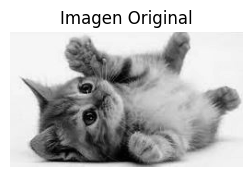

In [6]:
# Paso 1: Cargar la imagen en tonos de gris
# 'dibu_Violin.png', 'gato03.jpg'
img_path = 'Gato02.jpg'  # Reemplaza con la ruta de tu imagen
img = load_img(img_path, color_mode='grayscale') 
img_array = img_to_array(img)

print(img_array.shape)
img_alto = img_array.shape[0]
img_ancho = img_array.shape[1]
img_canales = img_array.shape[2]

# Visualizar la imagen original
plt.figure(figsize=(3, 3))
plt.imshow(img_array.squeeze(), cmap='gray')
plt.title('Imagen Original')
plt.axis('off')
plt.show()

### Filtro a utilizar

In [7]:
opcion = 2   # para elegir si se usarán filtros de 3x3 o de 2x2
if (opcion==1):
    filtro1 = np.array([[ 1,  1,  1], 
                        [ 0,  0,  0], 
                        [-1, -1, -1]], dtype='float32')
elif (opcion==2):    
    filtro1 = np.array([[ 1,  1,  1], 
                        [ 0,  0,  0], 
                        [-1, -1, -1]], dtype='float32')
    
    filtro2 = np.array([[-1, -1,  0], 
                        [-1,  0,  1], 
                        [ 0,  1,  1]], dtype='float32')
    
    filtro3 = np.array([[ 1,  1,  0], 
                        [ 1,  0, -1], 
                        [ 0, -1, -1]], dtype='float32')
else:
    filtro1 = np.array([[ 1,  1], 
                        [-1, -1]], dtype='float32')
    
    filtro2 = np.array([[-1,  0], 
                        [ 0,  1]], dtype='float32')
    
    filtro3 = np.array([[ 1,  0], 
                        [ 0, -1]], dtype='float32')

In [8]:
# combinamos los filtros en un arreglo que tendrá 3 dimensiones. La última corresponde al nro. de filtro
if (opcion==1):
    filtros = filtro1.reshape((3,3, 1))
else:
    filtros = np.stack([filtro1, filtro2, filtro3], axis=-1)

print("Primer filtro\n")
print(filtros[:,:,0])

Primer filtro

[[ 1.  1.  1.]
 [ 0.  0.  0.]
 [-1. -1. -1.]]


### Definición del modelo

In [9]:
# Hiperparámetros

# los filtros tienen igual cantidad de filas que de columnas y son todos iguales    
K = filtros.shape[0]  # el tamaño de todos los filtros será de KxK
print("Tamaño de cada filtro: ", K, "x", K)

F = filtros.shape[2]  # el último índice corresponde al número de filtro
print("Cantidad de filtros a utilizar: ", F)
S = 1                 # usaremos stride de 1
P = 'valid'           # sin padding


Tamaño de cada filtro:  3 x 3
Cantidad de filtros a utilizar:  3


In [10]:
# Definición del modelo secuencial formado por una única capa convoclucional
model = Sequential()
model.add(Conv2D(F, (K, K), strides=(S, S), padding = P, 
                 input_shape=(img_alto, img_ancho, img_canales),  
                 use_bias=False))
model.summary()


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 145, 251, 3)    │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27 (108.00 B)

 Trainable params: 27 (108.00 B)

 Non-trainable params: 0 (0.00 B)

### Asignamos los filtros a la capa convolucional

In [11]:
# Redimensionar el arreglo de filtros para que sea compatible con la capa Conv2D
# (altura del filtro, ancho del filtro, canales de entrada, canales de salida o cantidad de filtros)
filtros_Conv = filtros.reshape((K,K, img_canales, F))

# Asignamos los filtros
model.layers[0].set_weights([filtros_Conv])


### Aplicando la capa convolucional

In [12]:
# Ajustar el tamaño para que sea compatible con el modelo

# Keras espera que las entradas del modelo tengan una forma de (batch_size, height, width, channels), donde:
# -- batch_size es el número de imágenes en un lote (batch). Aquí usamos 1 porque estamos pasando una sola imagen.
# -- height es la altura de la imagen, que sigue siendo 158.
# -- width es el ancho de la imagen, que sigue siendo 152.
# -- channels es el número de canales de la imagen, que sigue siendo 1.
    
img_array = img_array.reshape((1, img_alto, img_ancho, img_canales))  

# Aplicar el filtro a la imagen
filtered_images = model.predict(img_array)
filtered_images.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


(1, 145, 251, 3)

### Resultados de la convolución

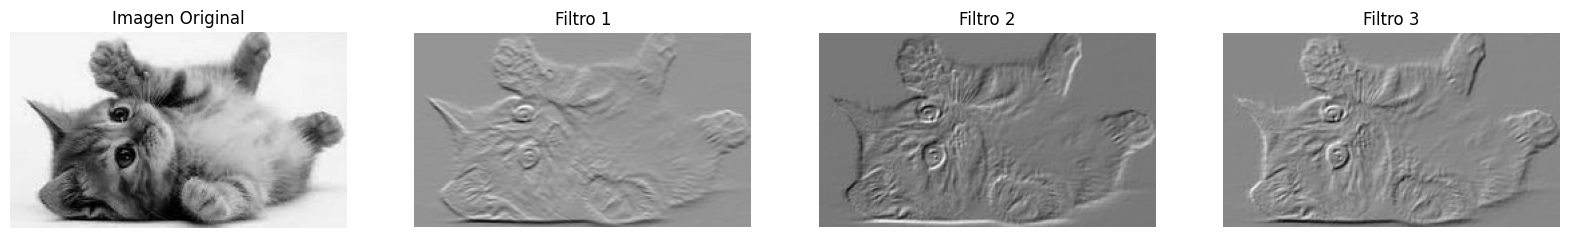

: 

In [13]:

# Visualizar la imagen original y las imágenes filtradas en un subplot
# F es la cantidad de filtros de la capa convolucional
fig, axes = plt.subplots(1, F+1, figsize=(20, 8))
axes[0].imshow(img_array.squeeze(), cmap='gray')
axes[0].set_title('Imagen Original')
axes[0].axis('off')

for i in range(F):
    axes[i+1].imshow(filtered_images[0, :, :, i], cmap='gray')
    axes[i+1].set_title(f'Filtro {i+1}')   # o también .set_title('Filtro '+str(i+1))
    axes[i+1].axis('off')

plt.show()